## 1. BMI & 체지방률 & 체지방량 & 근육량(제지방량)기반으로 체형 분류

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# -----------------------------
# 1. 파일 경로 & 데이터 불러오기
# -----------------------------
file_path_dataset = r"C:/project/finfit/static/dataset/final_dataset_v6.csv"
df = pd.read_csv(file_path_dataset)

print(df.shape)


(6811, 50)


In [10]:
df.isna().sum()

id                             0
year                           0
region                         0
sex                            0
age                            0
age_group_id                   0
height                         0
weight                         0
bmi                            0
bmi_category                   0
alchol                         0
smoking_history                0
dyslipidemia_status            0
chol_total                   729
chol_hdl                     729
chol_ldl                     729
chol_tg                      729
diabetes                       0
fasting_blood_sugar          729
glycated_hemoglobin          748
high_blood_pressure            0
sbp_average                  301
dbp_average                  301
cancer_diagnosis_fathers     822
cancer_diagnosis_mother      822
cancer_diagnosis_sibling     822
white_blood_cell_count       735
red_blood_cell_count         735
alchol_1year                   0
sleeptime_day                  0
sleeptime_

In [11]:

# ------------------------------
# 2. BMI, 체지방률, 제지방량, 체지방량 계산 함수 정의
# ------------------------------
def calculate_bmi(weight, height):
    return weight / ((height / 100) ** 2)

def calculate_body_fat_percentage(bmi, age, sex):
    # Deurenberg 공식 사용
    return (1.20 * bmi) + (0.23 * age) - (16.2 if sex == 1 else 5.4)

def calculate_lean_body_mass(weight, body_fat_percentage):
    return weight * (1 - (body_fat_percentage / 100))

def calculate_fat_mass(weight, body_fat_percentage):
    return weight * (body_fat_percentage / 100)

# ------------------------------
# 3. 결측치 처리: 신장, 체중 기반 계산
# ------------------------------
df["bmi"] = df.apply(lambda row: calculate_bmi(row["weight"], row["height"]) 
                      if pd.isna(row["bmi"]) else row["bmi"], axis=1)

df["body_fat_percentage"] = df.apply(lambda row: calculate_body_fat_percentage(row["bmi"], row["age"], row["sex"]) 
                                      if pd.isna(row["body_fat_percentage"]) else row["body_fat_percentage"], axis=1)

df["total_lean_body_mass"] = df.apply(lambda row: calculate_lean_body_mass(row["weight"], row["body_fat_percentage"]) 
                                      if pd.isna(row["total_lean_body_mass"]) else row["total_lean_body_mass"], axis=1)

df["body_fat_mass"] = df.apply(lambda row: calculate_fat_mass(row["weight"], row["body_fat_percentage"]) 
                                if pd.isna(row["body_fat_mass"]) else row["body_fat_mass"], axis=1)

# ------------------------------
# 4. 체형 분류 함수 (성별 + 체지방률 + 제지방량 기준)
# ------------------------------
def classify_body_type_final(bmi, body_fat_percentage, lean_mass_ratio, sex):
    if sex == 1:  # 남성
        if bmi < 18.5:
            return "마른 비만형" if body_fat_percentage >= 25 else "마른형"
        elif 18.5 <= bmi < 23:
            return "표준형"
        elif 23 <= bmi < 25:
            return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 20 and lean_mass_ratio > 0.7:
                return "근육형"
            else:
                return "비만형"
        else:  # BMI ≥ 30
            if body_fat_percentage < 25 and lean_mass_ratio > 0.7:
                return "근육형"
            elif body_fat_percentage >= 30:
                return "근육형 비만형"
            else:
                return "비만형"
    else:  # 여성
        if bmi < 18.5:
            return "마른 비만형" if body_fat_percentage >= 32 else "마른형"
        elif 18.5 <= bmi < 23:
            return "표준형"
        elif 23 <= bmi < 25:
            return "과체중형"
        elif 25 <= bmi < 30:
            if body_fat_percentage < 28 and lean_mass_ratio > 0.65:
                return "근육형"
            else:
                return "비만형"
        else:  # BMI ≥ 30
            if body_fat_percentage < 32 and lean_mass_ratio > 0.65:
                return "근육형"
            elif body_fat_percentage >= 35:
                return "근육형 비만형"
            else:
                return "비만형"

# ------------------------------
# 5. 체형 컬럼 생성
# ------------------------------
df["lean_mass_ratio"] = df["total_lean_body_mass"] / df["weight"]
df["body_type"] = df.apply(lambda row: classify_body_type_final(
    row["bmi"], row["body_fat_percentage"], row["lean_mass_ratio"], row["sex"]
), axis=1)

# 확인
print(df["body_type"].value_counts())


body_type
표준형        2479
비만형        1774
과체중형       1374
마른형         794
근육형 비만형     329
근육형          46
마른 비만형       15
Name: count, dtype: int64


In [12]:
print(df.columns)  # 현재 컬럼 확인

Index(['id', 'year', 'region', 'sex', 'age', 'age_group_id', 'height',
       'weight', 'bmi', 'bmi_category', 'alchol', 'smoking_history',
       'dyslipidemia_status', 'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
       'diabetes', 'fasting_blood_sugar', 'glycated_hemoglobin',
       'high_blood_pressure', 'sbp_average', 'dbp_average',
       'cancer_diagnosis_fathers', 'cancer_diagnosis_mother',
       'cancer_diagnosis_sibling', 'white_blood_cell_count',
       'red_blood_cell_count', 'alchol_1year', 'sleeptime_day',
       'sleeptime_weekday', 'hour_sitting', 'minute_sitting', 'walk_day',
       'walk_hour', 'walk_minute', 'weight_day', 'weight_hour',
       'body_activity', 'stress', 'breakfast_frequency', 'lunch_frequency',
       'dinner_frequency', 'diningout_frequency', 'daily_vegetable_intake',
       'daily_fruit_intake', 'water_intake', 'total_lean_body_mass',
       'body_fat_mass', 'body_fat_percentage', 'lean_mass_ratio', 'body_type'],
      dtype='object')


In [ ]:
# ------------------------------
# 1. 결측치 처리
# ------------------------------

# (1) body_activity 결측치 처리 함수 정의
def calculate_body_activity(weight_day, weight_hour, walk_day, walk_hour, walk_minute, hour_sitting, minute_sitting):
    """
    개선된 신체활동 여부 판단
    - ① 유산소(걷기): 총 주간 시간 계산
    - ② 근력운동: 총 주간 시간 계산
    - ③ 둘 중 하나라도 기준치 넘으면 '1'
    - 단, 앉아있는 시간이 너무 길면 '0'
    """
    walk_total_min = walk_day * ((walk_hour * 60) + walk_minute)
    weight_total_min = weight_day * weight_hour * 60
    sitting_total_min = hour_sitting * 60 + minute_sitting

    # 운동 조건 만족 여부
    activity_condition = (walk_total_min + weight_total_min >= 150) or (weight_total_min >= 75)

    # 장시간 앉아있을 경우 비활동적 간주
    sitting_condition = sitting_total_min < 600  # 10시간 미만

    return 1 if activity_condition and sitting_condition else 0


df["body_activity"] = df.apply(
    lambda row: calculate_body_activity(
        row["weight_day"], row["weight_hour"],
        row["walk_day"], row["walk_hour"], row["walk_minute"],
        row["hour_sitting"], row["minute_sitting"]
    ) if pd.isna(row["body_activity"]) else row["body_activity"],
    axis=1
)

# body_activity 여전히 결측치가 있는 행은 삭제
df.dropna(subset=["body_activity"], inplace=True)

# 'id' 컬럼 제외
df = df.drop(columns=['id'])

# (1) 숫자형 컬럼만 추출
num_cols = df.select_dtypes(include='number').columns

# (2) 숫자형 컬럼에 대해서만 평균으로 결측치 채우기
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())


# # (3) 나머지 결측치는 평균값으로 처리
# df.fillna(df.mean(), inplace=True)

In [14]:
df.isna().sum()

year                        0
region                      0
sex                         0
age                         0
age_group_id                0
height                      0
weight                      0
bmi                         0
bmi_category                0
alchol                      0
smoking_history             0
dyslipidemia_status         0
chol_total                  0
chol_hdl                    0
chol_ldl                    0
chol_tg                     0
diabetes                    0
fasting_blood_sugar         0
glycated_hemoglobin         0
high_blood_pressure         0
sbp_average                 0
dbp_average                 0
cancer_diagnosis_fathers    0
cancer_diagnosis_mother     0
cancer_diagnosis_sibling    0
white_blood_cell_count      0
red_blood_cell_count        0
alchol_1year                0
sleeptime_day               0
sleeptime_weekday           0
hour_sitting                0
minute_sitting              0
walk_day                    0
walk_hour 

In [15]:
print(df.columns)  # 현재 컬럼 확인

Index(['year', 'region', 'sex', 'age', 'age_group_id', 'height', 'weight',
       'bmi', 'bmi_category', 'alchol', 'smoking_history',
       'dyslipidemia_status', 'chol_total', 'chol_hdl', 'chol_ldl', 'chol_tg',
       'diabetes', 'fasting_blood_sugar', 'glycated_hemoglobin',
       'high_blood_pressure', 'sbp_average', 'dbp_average',
       'cancer_diagnosis_fathers', 'cancer_diagnosis_mother',
       'cancer_diagnosis_sibling', 'white_blood_cell_count',
       'red_blood_cell_count', 'alchol_1year', 'sleeptime_day',
       'sleeptime_weekday', 'hour_sitting', 'minute_sitting', 'walk_day',
       'walk_hour', 'walk_minute', 'weight_day', 'weight_hour',
       'body_activity', 'stress', 'breakfast_frequency', 'lunch_frequency',
       'dinner_frequency', 'diningout_frequency', 'daily_vegetable_intake',
       'daily_fruit_intake', 'water_intake', 'total_lean_body_mass',
       'body_fat_mass', 'body_fat_percentage', 'lean_mass_ratio', 'body_type'],
      dtype='object')


In [16]:
# 전체 컬럼을 활용하여 특징(X) 설정
X = df.drop(columns=["year", "region", "bmi_category", "body_type"])  # 'body_type'을 제외한 모든 컬럼을 특징으로 사용
y = df["body_type"]  # 예측할 체형

# 데이터 확인
df["body_type"].value_counts()


body_type
표준형        2479
비만형        1774
과체중형       1374
마른형         794
근육형 비만형     329
근육형          46
마른 비만형       15
Name: count, dtype: int64

In [17]:
# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습/테스트 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [18]:
X_scaled.shape, y_encoded.shape

((6811, 47), (6811,))

In [19]:
# ------------------------------
# 랜덤 포레스트 모델 학습
# ------------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

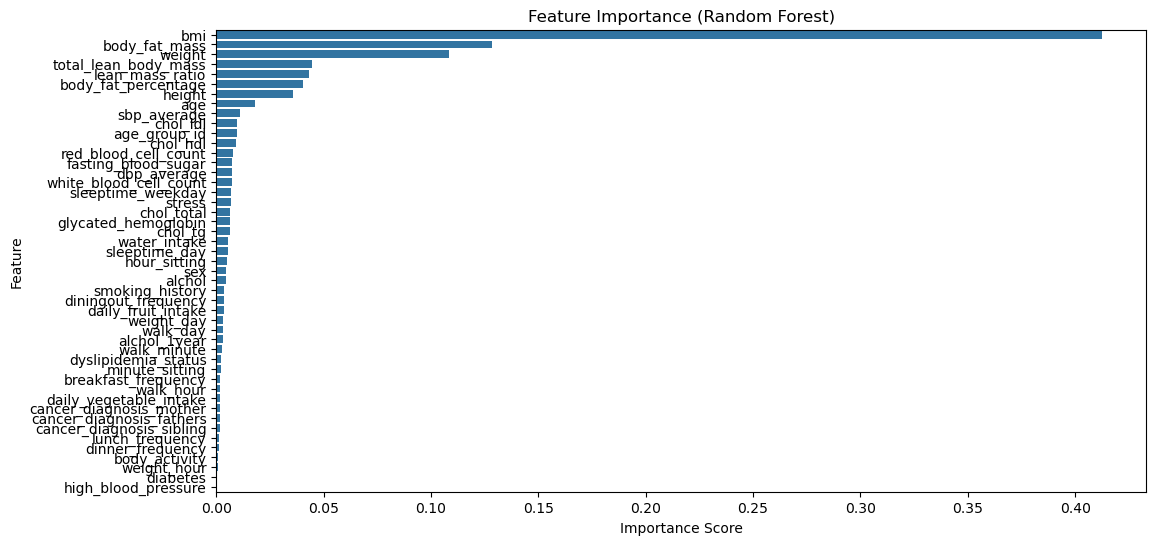

In [20]:
# ------------------------------
# 2️⃣ 교차 검증 (Cross Validation)
# ------------------------------
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# ------------------------------
# 3️⃣ 랜덤 포레스트 하이퍼파라미터 튜닝 (Grid Search)
# ------------------------------
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_

# ------------------------------
# 4️⃣ Feature Importance 분석 (랜덤 포레스트 기준)
# ------------------------------
feature_importances = best_rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# ------------------------------
# 5️⃣ 오버피팅 여부 확인 (Train vs Test 정확도 비교)
# ------------------------------
train_acc_rf = best_rf_model.score(X_train, y_train)
test_acc_rf = best_rf_model.score(X_test, y_test)

# ------------------------------
# 📊 Feature Importance 시각화
# ------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'])
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [21]:
# 결과 출력
cv_scores_rf.mean(), best_rf_params, train_acc_rf, test_acc_rf

(0.9799941028297992,
 {'max_depth': 20,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 200},
 0.9998164464023495,
 0.9904622157006603)

In [22]:
# 랜덤 포레스트 평가
rf_acc = accuracy_score(y_test, rf_preds)
rf_report = classification_report(y_test, rf_preds, target_names=label_encoder.classes_)

c:\Users\human\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\human\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\human\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# 결과 출력
rf_acc, rf_report

(0.9904622157006603,
 '              precision    recall  f1-score   support\n\n        과체중형       0.99      1.00      0.99       275\n         근육형       1.00      0.67      0.80         9\n     근육형 비만형       1.00      0.97      0.98        66\n      마른 비만형       0.00      0.00      0.00         3\n         마른형       0.99      0.99      0.99       159\n         비만형       0.99      0.99      0.99       355\n         표준형       0.99      1.00      1.00       496\n\n    accuracy                           0.99      1363\n   macro avg       0.85      0.80      0.82      1363\nweighted avg       0.99      0.99      0.99      1363\n')

In [ ]:
# ------------------------------
# 모델 저장
# ------------------------------

# 딕셔너리 형태로 묶어서 저장
bundle = {
    'model': rf_model,
    'scaler': scaler,
    'label_encoder': label_encoder
}

joblib.dump(bundle, "models/exercise_models.pkl")


['models/exercise_models.pkl']

In [28]:
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 저장된 하나의 파일을 로드
bundle = joblib.load("models/exercise_models.pkl")

# 개별 요소 꺼내기
rf_model = bundle['model']
scaler = bundle['scaler']
label_encoder = bundle['label_encoder']


# 모델이 학습한 Feature 목록 가져오기
model_features = scaler.feature_names_in_

# 사용자 입력 데이터 (예시)
user_data = {
    "age": 30,
    "height": 175.0,
    "weight":70.0,
    "bmi": 70.0 / ((175.0 / 100) ** 2),
    "alchol": 1,
    "smoking_history": 0,
    "sex": 1
}

# 입력 데이터를 데이터프레임으로 변환
df_input = pd.DataFrame([user_data])

# 누락된 컬럼을 평균값으로 채우기
for col in model_features:
    if col not in df_input.columns:
        df_input[col] = df[col].mean()  # 평균값으로 채움

def calculate_body_fat_percentage(bmi, age, sex):
    # Deurenberg 공식 사용
    return (1.20 * bmi) + (0.23 * age) - (16.2 if sex == 1 else 5.4)

def calculate_lean_body_mass(weight, body_fat_percentage):
    return weight * (1 - (body_fat_percentage / 100))

def calculate_fat_mass(weight, body_fat_percentage):
    return weight * (body_fat_percentage / 100)

# 결측치 처리
df["body_fat_percentage"] = df.apply(lambda row: calculate_body_fat_percentage(row["bmi"], row["age"], row["sex"]) 
                                      if pd.isna(row["body_fat_percentage"]) else row["body_fat_percentage"], axis=1)

df["total_lean_body_mass"] = df.apply(lambda row: calculate_lean_body_mass(row["weight"], row["body_fat_percentage"]) 
                                      if pd.isna(row["total_lean_body_mass"]) else row["total_lean_body_mass"], axis=1)

df["body_fat_mass"] = df.apply(lambda row: calculate_fat_mass(row["weight"], row["body_fat_percentage"]) 
                                if pd.isna(row["body_fat_mass"]) else row["body_fat_mass"], axis=1)

# Feature 순서 일치시키기
df_input = df_input[model_features]
df_input_scaled = scaler.transform(df_input)

# 예측 수행
prediction = rf_model.predict(df_input_scaled)
predicted_body_type = label_encoder.inverse_transform(prediction)

print(f"예측된 체형: {predicted_body_type[0]}")


예측된 체형: 표준형
